In [11]:
import torch
from torch.autograd import Variable
import numpy as np

class RealNVP(torch.nn.Module):
    """

    Args:
        Nvars (int): number variables.
        Nlayers (int): number of layers.
        Hs (int): number of hidden neurons of the s neural network.
        Ht (int): number of hidden neurons of the t neural network.

    """
    def __init__(self, Nvars, Nlayers=2,Hs=10, Ht=10):
        super(RealNVP, self).__init__()
        self.Nvars = Nvars
        self.Nhalf = int(Nvars/2)
        self.Nlayers = Nlayers
        self.Hs = Hs
        self.Ht = Ht

        self.name ='realnvp'
        self.s = torch.nn.ModuleList()
        self.t = torch.nn.ModuleList()
        for i in range(self.Nlayers):
            if i != self.Nlayers-1:
                self.s.append (
                     torch.nn.Sequential(
                     torch.nn.Linear(self.Nhalf, Hs),
                     torch.nn.ReLU(),
                     torch.nn.Linear(Hs, self.Nhalf)
                     ))
            self.t.append(
                 torch.nn.Sequential(
                 torch.nn.Linear(self.Nhalf, Ht),
                 torch.nn.ReLU(),
                 torch.nn.Linear(Ht, self.Nhalf)
                 ))
            self.s.append(
                torch.nn.Sequential(
                torch.nn.Linear(self.Nhalf, Hs),
                torch.nn.ReLU(),
                torch.nn.Linear(Hs, self.Nhalf),
                torch.nn.Tanh()
                ))

    def forward(self, x):
        y0 = x[:,0:self.Nhalf]
        y1 = x[:,self.Nhalf:self.Nvars]
        self.logjac = Variable(torch.zeros(x.data.shape[0]))
        for i in range(self.Nlayers):
            if (i%2==0):
                y1 = y1 * torch.exp(self.s[i](y0))  + self.t[i](y0)
                self.logjac += self.s[i](y0).sum(dim=1)
            else:
                y0 = y0 * torch.exp(self.s[i](y1)) +  self.t[i](y1)
                self.logjac += self.s[i](y1).sum(dim=1)
        return torch.cat((y0, y1), 1)

    def backward(self, z):
        y0 = z[:,0:self.Nhalf]
        y1 = z[:,self.Nhalf:self.Nvars]
        self.logjac = Variable(torch.zeros(z.data.shape[0]))
        for i in list(range(self.Nlayers))[::-1]:
            if (i%2==1):
                y0 = (y0 - self.t[i](y1)) * torch.exp(-self.s[i](y1))
                self.logjac -= self.s[i](y1).sum(dim=1)
            else:
                y1 = (y1 - self.t[i](y0)) * torch.exp(-self.s[i](y0))
                self.logjac -= self.s[i](y0).sum(dim=1)
        return torch.cat((y0, y1), 1)

    def logp(self, x):
        z = self.backward(x)
        return -0.5*(z**2).sum(dim=1) + self.logjac

In [12]:
"Now, let's check model's reversibility"

"Now, let's check model's reversibility"

In [13]:
Nvars = 4
model = RealNVP(Nvars)
testX = Variable(torch.randn(1000,Nvars))
forward = model.forward(testX)
forwardLogjac = model.logjac
backward = model.backward(forward)
backwardLogjac = model.logjac
from numpy.testing import assert_array_almost_equal
assert_array_almost_equal(backward.data.numpy(),testX.data.numpy())
assert_array_almost_equal(forwardLogjac.data.numpy(),-backwardLogjac.data.numpy())

In [14]:
xy = np.loadtxt('train.dat', dtype=np.float32)
x_data = Variable(torch.from_numpy(xy[:, 0:-1]))
y_data = Variable(torch.from_numpy(xy[:, -1]))
Nvars = x_data.data.shape[-1]

In [15]:
Nepochs = 500
Nlayers = 4
Hs = 10
Ht = 10
model = RealNVP(Nvars, Nlayers,Hs,Ht)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)

In [16]:
for epoch in range(Nepochs):
    logp = model.logp(x_data)
    loss = -logp.mean()
    print("epoch:",epoch,"loss:",loss.data[0])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch: 0 loss: 2.906975507736206
epoch: 1 loss: 2.5029287338256836
epoch: 2 loss: 2.246962070465088
epoch: 3 loss: 2.08931565284729
epoch: 4 loss: 1.9974277019500732
epoch: 5 loss: 1.9490606784820557
epoch: 6 loss: 1.9271146059036255
epoch: 7 loss: 1.9180105924606323
epoch: 8 loss: 1.9117929935455322
epoch: 9 loss: 1.9021477699279785
epoch: 10 loss: 1.8866735696792603
epoch: 11 loss: 1.8659765720367432
epoch: 12 loss: 1.8424687385559082
epoch: 13 loss: 1.8192299604415894
epoch: 14 loss: 1.7991275787353516
epoch: 15 loss: 1.7838491201400757
epoch: 16 loss: 1.7729259729385376
epoch: 17 loss: 1.7637038230895996
epoch: 18 loss: 1.7528595924377441
epoch: 19 loss: 1.7391116619110107
epoch: 20 loss: 1.7241326570510864
epoch: 21 loss: 1.7107844352722168
epoch: 22 loss: 1.7012921571731567
epoch: 23 loss: 1.6960116624832153
epoch: 24 loss: 1.6938399076461792
epoch: 25 loss: 1.6929726600646973
epoch: 26 loss: 1.6917515993118286
epoch: 27 loss: 1.6889158487319946
epoch: 28 loss: 1.6839507818222046

epoch: 237 loss: 1.3590619564056396
epoch: 238 loss: 1.3589632511138916
epoch: 239 loss: 1.3584346771240234
epoch: 240 loss: 1.3580108880996704
epoch: 241 loss: 1.3579766750335693
epoch: 242 loss: 1.3581408262252808
epoch: 243 loss: 1.358177900314331
epoch: 244 loss: 1.357875108718872
epoch: 245 loss: 1.3574271202087402
epoch: 246 loss: 1.357079267501831
epoch: 247 loss: 1.3570373058319092
epoch: 248 loss: 1.357246994972229
epoch: 249 loss: 1.3574954271316528
epoch: 250 loss: 1.3569786548614502
epoch: 251 loss: 1.3575750589370728
epoch: 252 loss: 1.358542561531067
epoch: 253 loss: 1.3565714359283447
epoch: 254 loss: 1.359809160232544
epoch: 255 loss: 1.3611360788345337
epoch: 256 loss: 1.3621931076049805
epoch: 257 loss: 1.356730341911316
epoch: 258 loss: 1.366104006767273
epoch: 259 loss: 1.3681166172027588
epoch: 260 loss: 1.3801569938659668
epoch: 261 loss: 1.3701719045639038
epoch: 262 loss: 1.3583049774169922
epoch: 263 loss: 1.3863598108291626
epoch: 264 loss: 1.3677366971969604


epoch: 474 loss: 1.3385868072509766
epoch: 475 loss: 1.3385944366455078
epoch: 476 loss: 1.3386238813400269
epoch: 477 loss: 1.3386322259902954
epoch: 478 loss: 1.338653326034546
epoch: 479 loss: 1.3386034965515137
epoch: 480 loss: 1.3385450839996338
epoch: 481 loss: 1.3384754657745361
epoch: 482 loss: 1.338404655456543
epoch: 483 loss: 1.338361144065857
epoch: 484 loss: 1.3383208513259888
epoch: 485 loss: 1.3382768630981445
epoch: 486 loss: 1.3382495641708374
epoch: 487 loss: 1.3382333517074585
epoch: 488 loss: 1.3382556438446045
epoch: 489 loss: 1.3382720947265625
epoch: 490 loss: 1.3383122682571411
epoch: 491 loss: 1.3383203744888306
epoch: 492 loss: 1.3383452892303467
epoch: 493 loss: 1.3382139205932617
epoch: 494 loss: 1.338112473487854
epoch: 495 loss: 1.3379367589950562
epoch: 496 loss: 1.3377728462219238
epoch: 497 loss: 1.337666392326355
epoch: 498 loss: 1.3376128673553467
epoch: 499 loss: 1.337605595588684


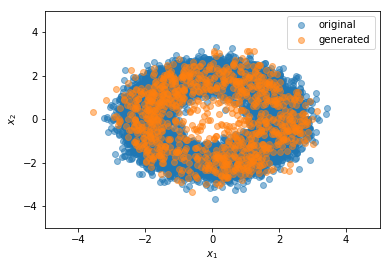

In [18]:
import matplotlib.pyplot as plt
Nsamples = 1000
z = Variable(torch.randn(Nsamples, Nvars), volatile=True)
x = model.forward(z)
plt.figure()
plt.scatter(x_data[:,0], x_data[:,1], alpha=0.5, label='original')
plt.scatter(x[:,0], x[:,1], alpha=0.5, label='generated')
plt.xlim([-5, 5])
plt.ylim([-5, 5])

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.show()